#### 1. Import and clean data

In [1]:
from io import open
import glob
import os

files_path = 'data/names/*.txt'
def find_files(path): return(glob.glob(path))

print(find_files(files_path))


['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Hausa.txt', 'data/names\\Igbo.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt', 'data/names\\Yoruba.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

#Turn unicode strings to ASCII
def unicode_to_ascii(s):
    return ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn' and char in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
category_words = {}
all_categories = []

# read a file and split it into lines
def read_words(file_name):
    words = open(file_name, encoding='utf-8').read().strip().split('\n')
    return[unicode_to_ascii(word) for word in words]

for file_name in find_files(files_path):
    category = os.path.splitext(os.path.basename(file_name))[0]
    all_categories.append(category)
    words = read_words(file_name)
    category_words[category] = words

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 21 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Hausa', 'Igbo', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese', 'Yoruba']


#### 2. Convert words to tensors

In [4]:
import torch, random

def letter_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_index(letter)] = 1
    return tensor

def input_tensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for index, letter in enumerate(word):
        tensor[index][0][letter_index(letter)] = 1
    return tensor

def category_tensor(category):
    index = all_categories.index(category)
    tensor =  torch.zeros(1, n_categories)
    tensor[0][index] = 1
    return tensor

def target_tensor(word):
    letter_indexes = [
        all_letters.find(word[index])
        for index in range(1, len(word))
        ]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

def random_choice(list_item):
    return list_item[random.randint(0, len(list_item) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    word = random_choice(category_words[category])
    return category, word

def random_training_example():
    _category, _word = random_training_pair()
    _category_tensor = category_tensor(_category)
    _input_tensor = input_tensor(_word)
    _target_tensor = target_tensor(_word)
    return _category_tensor, _input_tensor, _target_tensor
    
print(letter_index('A'))
print(letter_to_tensor('a'))
print(input_tensor('abc').size())
print(category_tensor('Irish'))
print(target_tensor('Cheng'))
for i in range(10):
    category, word  = random_training_pair()
    print('category:', category, '\t|\t word:', word)

26
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])
torch.Size([3, 1, 59])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([ 7,  4, 13,  6, 58])
category: Vietnamese 	|	 word: Doan
category: Polish 	|	 word: Piatek
category: Korean 	|	 word: Chu
category: Czech 	|	 word: Urista
category: Chinese 	|	 word: Won
category: Vietnamese 	|	 word: Kim
category: Portuguese 	|	 word: Albuquerque
category: Chinese 	|	 word: Dan
category: Irish 	|	 word: O'Kane
category: German 	|	 word: Herrmann


#### 3. RNN Network design
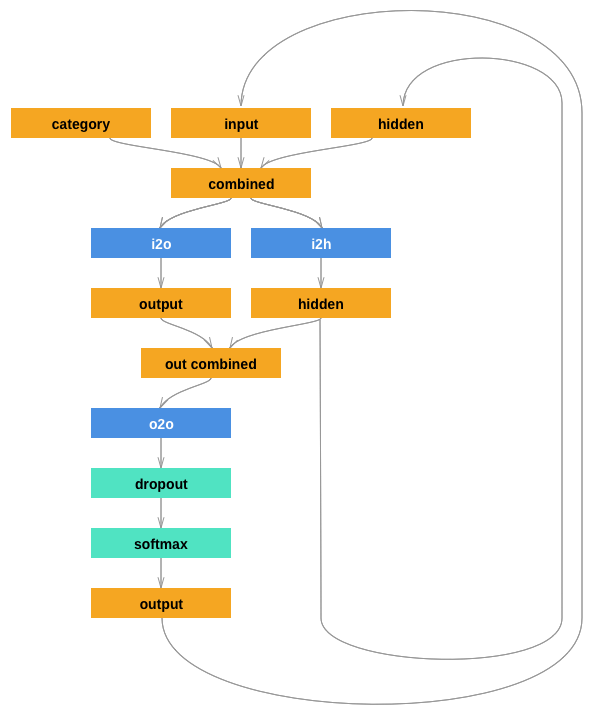

In [5]:
import torch
import torch.nn as nn
from torchinfo import summary


class RNNWordGen(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNWordGen, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    


#### 4. Training

In [6]:
criterion = nn.NLLLoss()
learning_rate = 5e-4

def train(category_tensor, input_tensor, target_tensor):
    target_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    losses = torch.Tensor([0])

    for i in range(input_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_tensor[i], hidden)
        loss = criterion(output, target_tensor[i])
        losses += loss

    losses.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, losses.item() / input_tensor.size(0)

In [7]:
import time
import math

n_hidden = 256
rnn = RNNWordGen(n_letters, n_hidden, n_letters)
print(summary(rnn))

n_iters = 10000
print_every = 5*n_iters//100
plot_every = print_every//5

total_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    sec = now - since
    min = math.floor(sec/60)
    sec -= min * 60
    return '%dm %ds' % (min, sec)

start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        print('%d\t %d%% (%s) %.4f' % (iter, iter / n_iters * 100, time_since(start), loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

model_path = 'models/name_generator.pt'
torch.save(rnn.state_dict(), model_path)

Layer (type:depth-idx)                   Param #
RNNWordGen                               --
├─Linear: 1-1                            86,272
├─Linear: 1-2                            19,883
├─Linear: 1-3                            18,644
├─Dropout: 1-4                           --
├─LogSoftmax: 1-5                        --
Total params: 124,799
Trainable params: 124,799
Non-trainable params: 0
500	 5% (0m 3s) 3.8494
1000	 10% (0m 6s) 3.1328
1500	 15% (0m 9s) 3.0696
2000	 20% (0m 12s) 3.2185
2500	 25% (0m 15s) 3.1513
3000	 30% (0m 17s) 3.5185
3500	 35% (0m 20s) 2.4822
4000	 40% (0m 22s) 2.8840
4500	 45% (0m 25s) 3.0887
5000	 50% (0m 28s) 2.4358
5500	 55% (0m 30s) 2.7415
6000	 60% (0m 33s) 2.7018
6500	 65% (0m 35s) 3.3389
7000	 70% (0m 38s) 3.2702
7500	 75% (0m 40s) 2.9842
8000	 80% (0m 43s) 3.3026
8500	 85% (0m 46s) 2.8754
9000	 90% (0m 48s) 2.2983
9500	 95% (0m 51s) 2.4995
10000	 100% (0m 53s) 1.8849


In [8]:
rnn = RNNWordGen(n_letters, n_hidden, n_letters)
rnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

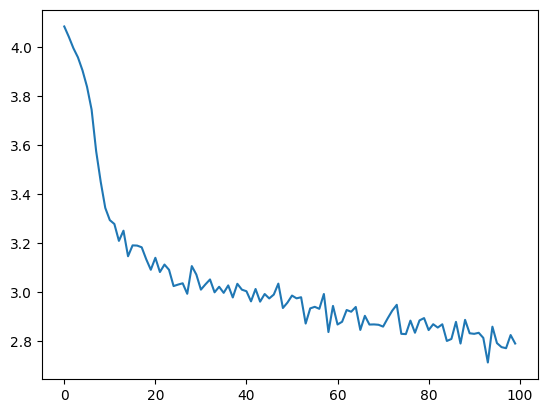

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#### 5. Evaluation

In [10]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# return an output give a word
def evaluate(word_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(word_tensor.size()[0]):
        output, hidden = rnn(word_tensor[i], hidden)
    
    return output

#record correct guesses from examples
for i in range(n_confusion):
    _category, word, category_tensor, word_tensor = random_training_pair()
    output = evaluate(word_tensor)
    guess, guess_idx = category_from_output(output)
    category_idx = all_categories.index(_category)
    confusion[category_idx][guess_idx] += 1
    
# normalize confusion
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()

#plot 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

ValueError: not enough values to unpack (expected 4, got 2)

In [12]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        _category_tensor = category_tensor(category)
        input = input_tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(_category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'JMA')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Jaana
Manan
Aanan
Goan
Eanan
Rana
Sana
Pana
Aanan
Can
Hon
Iana


In [13]:
sample('Arabic')

'Aana'